# Reinforcement Learning : Proximal Policy Optimization
***


## Reinforcement Learning : A Short intro 

* Reinforcement learning is a way to learn by interacting with environment and gradually improve performance 
by trial and error.
* Mostly used in robotics and gaming environment, the agents developed using reinforcement learning have become 
pretty robust to be used in other areas as well. 
* Due to the complicated, nonlinear patterns and low signal noise ratio in financial market data, 
  deep reinforcement learning is believed to be a potential fit. 



## Proximal Policy Optimization 

<video controls src="knocked-over-stand-up.mp4" />

* PPO lets us train AI policies in challenging environments, like the Roboschool one shown above where an agent tries to reach a target (the pink sphere), learning to walk, run, turn, use its momentum to recover from minor hits, and how to stand up from the ground when it is knocked over.

* Policy : Strategy that AI agent takes to achieve objective. 
* The overall complicatedness of RL algorithm is that, the training data is generated in real time that inturn is dependent on the policy used by an agent. 
* Thus data distribution changes constantly over changing rewards and objectives as the agent is learning; this causes major instability in whole training process. 
* Another problem with RL is hyperparameter tunning and initialization.
* PPO came in to solve many such problems and limitations in RL.
* The major intend of PPO was easy implementation (both algorighmically as well as resource-wise) and easy tunning. 




* PPO is based on Policy Gradient method : This means its learning is online which means instead of learning from stored data of past action, the agent relies on the actions encountered on the go. 

* Thus the agent takes batch of experience to update gradient, then whole batch is discarded and policy moves on. 


* Next, PPO is based on TRPO __(Trust Region Policy Optimization)__  TRPO sets the lower bound for policy improvement to avoid policy vanishing problem. 


__Policy Gradient__ 

<img src="image/PG.png">

*  Pi Theta : Policy
*  A : Advantage Function , it tries to estimates relative values of selected actions in given action. 
* Advantage  = Discounted Rewards - Baseline (Value) estimate 
* Discounted Rewards  = Weighted sum of all the rewards in current episode 
* Baseline vaule estimate is the guessing of the final reward in this episode. 
* Thus, combinely, Overall gives optimization objection 



__PPO__ 

<img src="image/ppo_eqn.png">

* E : Expectation, means this function is operated in several batches. 
* r X A : Normal policy gradient objective, meaning that r pushes the objective to __maximise Advantage Function__
* Epsilon : Hyperparameter 

__Clip Function__ 
<img src="image/clip.png">


What it says : 

 Left : The last action taken was good so don't further update, rather stick to it. 

 Right : The last action was bad so undo it, so move gradient towards other direction in the amount proportional to the badness of this action take. 




### In this Project 


* Investigate if PPO can become a good algorithm for Portfolio management

__Portfolio__ : M risk assets(stocks)  +  1 risk-free asset(money)  (M=5 in our experiments)
 
 __Action__ : Reallocation at the end of the day
 
 __Data Set__ : Several companies' Data from Sanghai Stock Exchange and NASDAQ from 2007 to 2018. 
 
 __Feature__ : Common features include the closing price, the open price, the high price, the low price and volume. Several researches have concluded the combination of Closing Price and High Price, so sticking to that.     

In [22]:
from argparse import ArgumentParser
import json
import pandas as pd
import numpy as np
import math
from decimal import Decimal
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from agents.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from agents.pg import PG
import datetime
import os
import seaborn as sns
sns.set_style("darkgrid")


In [23]:
#Parameter Initialization

eps=10e-8
epochs=0
M=0
PATH_prefix=''

In [3]:
#Stock Trader 

class StockTrader():
    def __init__(self):
        self.reset()

    def reset(self):
        self.wealth = 10e3         # Started with Initial amount 10000 for the agent to start trading 
        self.total_reward = 0
        self.ep_ave_max_q = 0
        self.loss = 0
        self.actor_loss=0

        self.wealth_history = []
        self.r_history = []
        self.w_history = []
        self.p_history = []
        self.noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(M))      # Noise added during learning process to simulate real trading scenerio 

    def update_summary(self,loss,r,q_value,actor_loss,w,p):
        self.loss += loss
        self.actor_loss+=actor_loss
        self.total_reward+=r
        self.ep_ave_max_q += q_value
        self.r_history.append(r)
        self.wealth = self.wealth * math.exp(r)
        self.wealth_history.append(self.wealth)
        self.w_history.extend([','.join([str(Decimal(str(w0)).quantize(Decimal('0.00'))) for w0 in w.tolist()[0]])])
        self.p_history.extend([','.join([str(Decimal(str(p0)).quantize(Decimal('0.000'))) for p0 in p.tolist()])])

    def write(self,codes,agent):
        global PATH_prefix
        wealth_history = pd.Series(self.wealth_history)
        r_history = pd.Series(self.r_history)
        w_history = pd.Series(self.w_history)
        p_history = pd.Series(self.p_history)
        history = pd.concat([wealth_history, r_history, w_history, p_history], axis=1)
        history.to_csv(PATH_prefix+agent + '-'.join(codes) + '-' + str(math.exp(np.sum(self.r_history)) * 100) + '.csv')

    def print_result(self,epoch,agent,noise_flag):
        self.total_reward=math.exp(self.total_reward) * 100
        print('*-----Episode: {:d}, Reward:{:.6f}%-----*'.format(epoch, self.total_reward))
        agent.write_summary(self.total_reward)
        agent.save_model()

    def plot_result(self):
        pd.Series(self.wealth_history).plot()
        plt.show()

    def action_processor(self,a,ratio):
        a = np.clip(a + self.noise() * ratio, 0, 1)
        a = a / (a.sum() + eps)
        return a

In [4]:
def parse_info(info):
    return info['reward'],info['continue'],info[ 'next state'],info['weight vector'],info ['price'],info['risk']

In [5]:
def traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable):
    info = env.step(None,None,noise_flag)
    r,contin,s,w1,p,risk=parse_info(info)
    contin=1
    t=0

    while contin:
        #w2 = agent.predict(!s,w1)
        w2 = agent.predict(s,w1)

        env_info = env.step(w1, w2,noise_flag)
        r, contin, s_next, w1, p,risk = parse_info(env_info)

        if framework=='PG':
            agent.save_transition(s,p,w2,w1)
        else:
            agent.save_transition(s, w2, r-risk, contin, s_next, w1)
        loss, q_value,actor_loss=0,0,0

        if framework=='DDPG':
            if not contin and trainable=="True":
                agent_info= agent.train(method,epoch)
                loss, q_value=agent_info["critic_loss"],agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PPO':
            if not contin and trainable=="True":
                agent_info = agent.train(method, epoch)
                loss, q_value = agent_info["critic_loss"], agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PG':
            if not contin and trainable=="True":
                agent.train()

        stocktrader.update_summary(loss,r,q_value,actor_loss,w2,p)
        s = s_next
        t=t+1



In [6]:
def maxdrawdown(arr):
    i = np.argmax((np.maximum.accumulate(arr) - arr)/np.maximum.accumulate(arr)) # end of the period
    j = np.argmax(arr[:i]) # start of period
    return (1-arr[i]/arr[j])

In [21]:
## Backtest is performed to see if the obtained policy works well. 

def backtest(agent,env):
    global PATH_prefix
    print("starting to backtest......")
    from agents.UCRP import UCRP
    from agents.Winner import WINNER
    from agents.Losser import LOSSER


    agents=[]
    agents.extend(agent)
    agents.append(WINNER())
    agents.append(UCRP())
    agents.append(LOSSER())
    labels=['PG','Winner','UCRP','Losser']

    wealths_result=[]
    rs_result=[]
    for i,agent in enumerate(agents):
        stocktrader = StockTrader()
        info = env.step(None, None,'False')
        r, contin, s, w1, p, risk = parse_info(info)
        contin = 1
        wealth=10000
        wealths = [wealth]
        rs=[1]
        while contin:
            w2 = agent.predict(s, w1)
            env_info = env.step(w1, w2,'False')
            r, contin, s_next, w1, p, risk = parse_info(env_info)
            wealth=wealth*math.exp(r)
            rs.append(math.exp(r)-1)
            wealths.append(wealth)
            s=s_next
            stocktrader.update_summary(0, r, 0, 0, w2, p)

        stocktrader.write(map(lambda x: str(x), env.get_codes()),labels[i])
        #print('finish one agent')
        wealths_result.append(wealths)
        rs_result.append(rs)

    print('Asset name ','   ','average daily rate of return','   ','sharp rate','   ','maximum retracement')
    plt.figure(figsize=(8, 6), dpi=100)
    for i in range(len(agents)):
        plt.plot(wealths_result[i],label=labels[i])
        mrr=float(np.mean(rs_result[i])*100)
        sharpe=float(np.mean(rs_result[i])/np.std(rs_result[i])*np.sqrt(252))
        maxdrawdown=float(max(1-min(wealths_result[i])/np.maximum.accumulate(wealths_result[i])))
        print(labels[i],'   ',round(mrr,3),'%','   ',round(sharpe,3),'  ',round(maxdrawdown,3))
    plt.legend()
    plt.savefig(PATH_prefix+'backtest.png')
    plt.show()

In [8]:
def parse_config(config,mode):
    codes = config["session"]["codes"]
    start_date = config["session"]["start_date"]
    end_date = config["session"]["end_date"]
    features = config["session"]["features"]
    agent_config = config["session"]["agents"]
    market = config["session"]["market_types"]
    noise_flag, record_flag, plot_flag=config["session"]["noise_flag"],config["session"]["record_flag"],config["session"]["plot_flag"]
    predictor, framework, window_length = agent_config
    reload_flag, trainable=config["session"]['reload_flag'],config["session"]['trainable']
    method=config["session"]['method']

    global epochs
    epochs = int(config["session"]["epochs"])

    if mode=='test':
        record_flag='True'
        noise_flag='False'
        plot_flag='True'
        reload_flag='True'
        trainable='False'
        method='model_free'

    print("*--------------------Training Status-------------------*")
    print("Date from",start_date,' to ',end_date)
    print('Features:',"PPO")
   
    print("Predictor:",predictor," Window_length:",window_length)
    print("Epochs:",epochs)
    print("Trainable:",trainable)
  


    return codes,start_date,end_date,features,agent_config,market,predictor, framework, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method


In [9]:
def session(config,args):
    global PATH_prefix
    from data.environment import Environment
    codes, start_date, end_date, features, agent_config, market,predictor, framework, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method=parse_config(config,args)
    env = Environment()

    global M
    M=codes+1

    stocktrader=StockTrader()
    PATH_prefix = "result/PG/" + str(args['num']) + '/'

    if args['mode']=='train':
        if not os.path.exists(PATH_prefix):
            os.makedirs(PATH_prefix)
            train_start_date, train_end_date, test_start_date, test_end_date, codes = env.get_repo(start_date, end_date,
                                                                                                   codes, market)
            env.get_data(train_start_date, train_end_date, features, window_length, market, codes)
            print("Codes:", codes)
            print('Training Time Period:', train_start_date, '   ', train_end_date)
            print('Testing Time Period:', test_start_date, '   ', test_end_date)
            with open(PATH_prefix + 'config.json', 'w') as f:
                json.dump({"train_start_date": train_start_date.strftime('%Y-%m-%d'),
                           "train_end_date": train_end_date.strftime('%Y-%m-%d'),
                           "test_start_date": test_start_date.strftime('%Y-%m-%d'),
                           "test_end_date": test_end_date.strftime('%Y-%m-%d'), "codes": codes}, f)
                print("finish writing config")
        else:
            with open("result/PG/" + str(args['num']) + '/config.json', 'r') as f:
                dict_data = json.load(f)
                print("successfully load config")
            train_start_date, train_end_date, codes = datetime.datetime.strptime(dict_data['train_start_date'],
                                                                               '%Y-%m-%d'), datetime.datetime.strptime(
                dict_data['train_end_date'], '%Y-%m-%d'), dict_data['codes']
            env.get_data(train_start_date, train_end_date, features, window_length, market, codes)

        for noise_flag in ['True']:#['False','True'] to train agents with noise and without noise in assets prices
            if framework == 'PG':
                print("*-----------------Loading PG Agent---------------------*")
                agent = PG(len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), reload_flag,
                           trainable,noise_flag,args['num'])

            print("Training with {:d}".format(epochs))
            for epoch in range(epochs):
                print("Now we are at epoch", epoch)
                traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable)

                if record_flag=='True':
                    stocktrader.write(epoch,framework)

                if plot_flag=='True':
                    stocktrader.plot_result()

                agent.reset_buffer()
                stocktrader.print_result(epoch,agent,noise_flag)
                stocktrader.reset()
            agent.close()
            del agent

    elif args['mode']=='test':
        with open("result/PG/" + str(args['num']) + '/config.json', 'r') as f:
            dict_data=json.load(f)
        test_start_date,test_end_date,codes=datetime.datetime.strptime(dict_data['test_start_date'],'%Y-%m-%d'),datetime.datetime.strptime(dict_data['test_end_date'],'%Y-%m-%d'),dict_data['codes']
        env.get_data(test_start_date,test_end_date,features,window_length,market,codes)
        backtest([PG(len(codes) + 1, int(window_length), len(features), '-'.join(agent_config), 'True','False','True',args['num'])],
                 env)


In [10]:
def main(args):
  
    with open('config.json') as f:
        config=json.load(f)
        if args['mode']=='download':
            from data.download_data import DataDownloader
            data_downloader=DataDownloader(config)
            data_downloader.save_data()
        else:
            session(config,args)
            



In [ ]:
#args = {"mode" : "train" , "num" : "None" }

In [ ]:
#main(args)

In [ ]:
#args = {"mode" : "test" , "num" : "None" }

*--------------------Training Status-------------------*
Date from 2007-01-01  to  2018-12-30
Features: PPO
Predictor: CNN  Window_length: 10
Epochs: 100
Trainable: True
Loading Model
./saved_network/PG/True/
Successfully loaded: ./result/PG/None/saved_network/True/CNN-PG-10-100
starting to backtest......
Asset name      average daily rate of return     sharp rate     maximum retracement
PG     0.137 %     0.581    0.518
Winner     -0.052 %     -0.213    0.847
UCRP     0.115 %     0.521    0.322
Losser     -0.283 %     -1.158    0.983


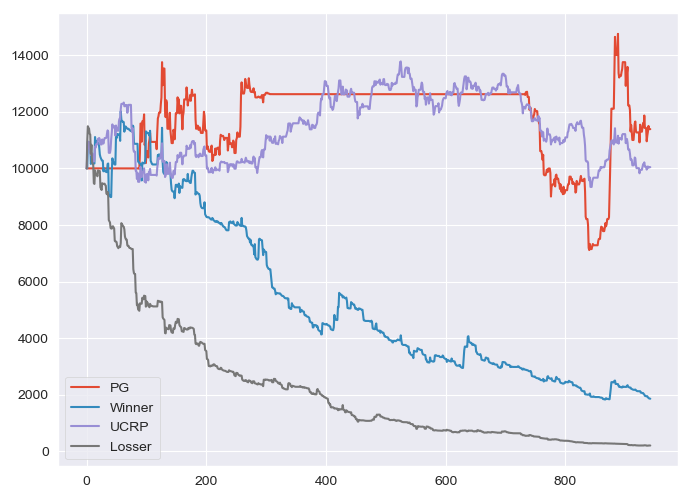

In [15]:
#main(args)

## Conclusion 

It’s found that deep reinforcement learning can somehow capture patterns of market movements even though it is allowed to observe limited data and features and self-improve its performance.

However, reinforcement learning does not gain such remarkable performance in portfolio management so far as those in game playing or robot control

### References 

* Groundai. “Deep Reinforcement Learning in Portfolio Management.” GroundAI, GroundAI, 29 Aug. 2018, www.groundai.com/project/deep-reinforcement-learning-in-portfolio-management/1.
* Proximal Policy Optimization Algorithms, https://openai.com/blog/openai-baselines-ppo/